In [32]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import copy
import dill

In [33]:
raw_data = pd.read_csv(r'data/new_graph.csv', sep='\t')
raw_data = raw_data.as_matrix()

C:\Users\Coco\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [34]:
raw_data

array([[         1,          2,          1, 1095183096],
       [         3,          4,          1, 1095183096],
       [         5,          6,          1, 1095183096],
       ...,
       [        15,         11,      33451, 1115253096],
       [        15,         11,      33451, 1115253096],
       [        15,         11,      33452, 1115253696]], dtype=int64)

### Network visualization

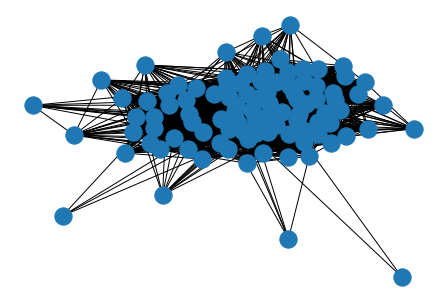

In [35]:
# generate the graph
graph = nx.Graph()

for row in raw_data:
    graph.add_edge(row[0], row[1])
    
nx.draw(graph)
plt.show()

### Network properties

In [36]:
N_nodes = graph.number_of_nodes()
print(f'Nr of nodes: {N_nodes}')

L_edges = graph.number_of_edges()
print(f'Nr of edges: {L_edges}')

p_density = nx.density(graph)
print(f'Link density: {p_density}')

D_mean = (2 * L_edges) / N_nodes
print(f'E[D]: {D_mean}')

D_var = (2 * L_edges * (N_nodes * (N_nodes - 1) - 2 * L_edges)) / (N_nodes * N_nodes * (N_nodes + 1))
print(f'Var[D]: {D_var}')

Nr of nodes: 96
Nr of edges: 2539
Link density: 0.5567982456140351
E[D]: 52.895833333333336
Var[D]: 22.96015446019473


### Degree distribution

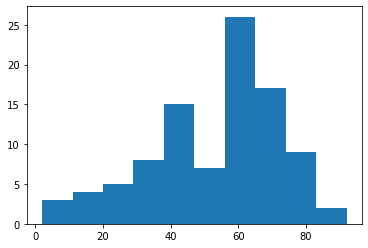

In [37]:
degrees = [num for i,num in graph.degree()]
plt.hist(degrees)
plt.show()

### Infection simulation

In [18]:
def simulate_infection(seed, data):
    # set of infected nodes (grows with every new infected node in the network)
    infected_nodes = set({seed})
    # list with number of infected nodes for every timestamp
    infected_nodes_time = list()
    # set of edges to be removed after simulation is done for current timestamp
    remove_edges = list()
    # store rank of seed node
    rank = None
    # store number of initial nodes infected by seed node (feature used to later rank nodes)
    initial_infections = 0     # this feature will be used in later questions to rank a node's influence
    initial_done = False
    # time at which seed infected first other node
    initial_infection_time = None

    # generate the graph
    graph = nx.Graph()

    # initial starting time
    t = 1
    for row in data:
        # simulation housekeeping when current timestamp is done (identified by t != current new time)
        if row[2] != t:
            time_diff = row[2] - t
            infected_nodes_time.append(len(infected_nodes) * time_diff)
            t = row[2]
            graph.clear()
            # graph.remove_edges_from(remove_edges)
            # remove_edges.clear()
            # stop checking for initial infected nodes
            if initial_infections != 0 and not initial_done:
                initial_done = True
        # build graph by adding edges (simulate infection / info spreading)
        graph.add_edge(row[0], row[1])
        # keep track of edges added at current timestamp (used when moving to next timestamp for removing them)
        # remove_edges.append((row[0], row[1]))
        if row[0] in infected_nodes or row[1] in infected_nodes:
            infected_nodes.update([row[0], row[1]])
            # logic for ranking a node's influence
            if len(infected_nodes) > 0.8 * N_nodes and rank is None:
                rank = t
        # check for initial infected nodes
        if (row[0] == seed or row[1] == seed) and not initial_done:
            initial_infections += 1
        # check whether the seed infects the initial node
        if initial_infection_time is None and (row[0] == seed or row[1] == seed):
            initial_infection_time = t
    infected_nodes_time.append(len(infected_nodes))
    
    return infected_nodes_time, rank, initial_infections, initial_infection_time

In [21]:
infections_list = []
ranks = dict()
initial_infections = dict()
initial_infection_times = dict()
for i in range(1, N_nodes + 1):
    res, rank, initial_infection, initial_infection_time = simulate_infection(i, raw_data)
    infections_list.append(res)
    ranks[i] = rank if rank is not None else raw_data[len(raw_data)-1][2]
    initial_infections[i] = initial_infection if initial_infection is not None else 0
    initial_infection_times[i] = initial_infection_time
    if i % 10 == 0:
        print(f'done with {i} items')
print(f'done with all items!')
        
infections = np.array(infections_list)
infections_mean = np.mean(infections, axis=0)
infections_var = np.var(infections, axis=0)

done with 10 items
done with all items!


In [ ]:
plt.plot(infections_mean)

### Infection simulation (multiprocessing)

In [22]:
import workers
from multiprocessing import Pool
from timeit import default_timer as timer

In [38]:
if __name__ == '__main__':
    _processes = 10
    p = Pool(processes = _processes)
    _start = timer()
    res = p.starmap(workers.simulate_infection, [(i, raw_data, N_nodes) for i in range(1, N_nodes + 1)])
    p.close()
    p.join()
    _end = timer()
    print(f'simulation time: {_end-_start}')

simulation time: 121.19252180000012


In [30]:
infections_list = []
for result in res:
    infections_list.append(result[0])
    
infections = np.array(infections_list)
infections_mean = np.mean(infections, axis=0)
infections_var = np.var(infections, axis=0)

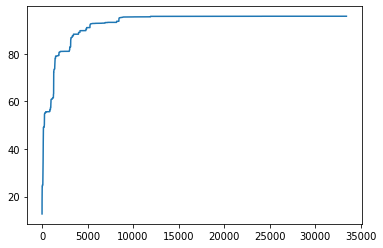

In [31]:
plt.plot(infections_mean)